# Analytical solution

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define the variable and the function
x = sp.symbols('x')
T = sp.Function('T')(x)

# Define the total derivative
dT_dx = T.diff(x)
d2T_dx2 = T.diff(x, 2)

# Create the equation using total derivatives
pde = sp.Eq(3 * dT_dx - 1*d2T_dx2, 1)

# Display the equation
#sp.pretty(pde)

# Solve the ODE with initial and final conditions
sol = sp.dsolve(pde, ics={T.subs(x, 0): 0, T.subs(x, 1): 0})  # Adjust the initial and final conditions as needed

# Define the range of x values
x_values = np.linspace(0, 1, 100)  # Adjust the range and number of points as needed

# Substitute the solution into the expression for T
T_values = [sol.rhs.subs(x, val).evalf() for val in x_values]


# create a local stiffness matrix

In [2]:
import sympy as sp
from scipy import integrate

# Define the variable and the functions
zi = sp.symbols('zi')
S1 = sp.Function('S1')(zi)
S2 = sp.Function('S2')(zi)

# Define shape functions
S1 = (1 - zi) / 2
S2 = (1 + zi) / 2

# Define the total derivative
dS1_dzi = S1.diff(zi)
dS2_dzi = S2.diff(zi)

# Define Je
Je = 0.1

# Define the combinations of shape functions
combinations = [(S1, S1), (S1, S2), (S2, S1), (S2, S2)]

# Initialize a dictionary to store the integration results
integration_results = np.array([])

# Perform integration for each combination
for combination in combinations:
    S1_comb, S2_comb = combination
    
    # Define the function to be integrated based on the combination
    def f(zi_value):
        S1_value = S1_comb.subs(zi, zi_value)
        dS1_dzi_value = S1_comb.diff(zi).subs(zi, zi_value)
        dS2_dzi_value = S2_comb.diff(zi).subs(zi, zi_value)
        return (S1_value * 3 * dS2_dzi_value * (1 / Je) + 1 * (dS1_dzi_value) * (1 / Je) * (dS2_dzi_value) * (1 / Je)) * Je
    
    # Use integrate.quad with the numerical function
    result, error = integrate.quad(f, -1, 1)
    
    # Store the result in the dictionary
    integration_results = np.append(integration_results,np.round(result,1))

print(integration_results)

[ 3.5 -3.5 -6.5  6.5]


# Assemble a global stiffness matrix

In [3]:
import numpy as np

# Number of nodes and elements
num_nodes = 6
num_elements = 5

# Initialize the global stiffness matrix
K_global = np.zeros((num_nodes, num_nodes))

# Define the local stiffness matrices for each element (assuming 2x2 matrices)
K_element_1 = np.array([[integration_results[0],integration_results[1] ],
                         [integration_results[2],integration_results[3]]])  # Replace k11, k12, k21, k22 with actual values

K_element_2 = np.array([[integration_results[0],integration_results[1] ],
                         [integration_results[2],integration_results[3]]])


# Define the connectivity of elements to nodes
element_node_connectivity = {
    1: [1, 2],
    2: [2, 3],
    3: [3, 4],
    4: [4, 5],
    5: [5, 6]
}

# Assemble the local stiffness matrices into the global stiffness matrix
for element in range(1, num_elements + 1):
    # Get the nodes associated with the current element
    nodes = element_node_connectivity[element]

    # Add the contributions of the local stiffness matrix to the global stiffness matrix
    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            # Map local degrees of freedom to global degrees of freedom
            global_dof_i = node_i - 1  
            global_dof_j = node_j - 1  

            # Add the contribution of the local stiffness matrix to the global stiffness matrix
            if node_i==node_j and node_i>1 and node_i<6:
                K_global[global_dof_i, global_dof_j] = K_element_1[i, j] + K_element_2[i-1, j-1]
            else:
                K_global[global_dof_i, global_dof_j] = K_element_1[i, j]
                

# Print the global stiffness matrix
print("Global Stiffness Matrix:")
print(K_global)

Global Stiffness Matrix:
[[ 3.5 -3.5  0.   0.   0.   0. ]
 [-6.5 10.  -3.5  0.   0.   0. ]
 [ 0.  -6.5 10.  -3.5  0.   0. ]
 [ 0.   0.  -6.5 10.  -3.5  0. ]
 [ 0.   0.   0.  -6.5 10.  -3.5]
 [ 0.   0.   0.   0.  -6.5  6.5]]


# Create a F matrix 

In [4]:
def g(zi_value):
        S1_value = S1.subs(zi, zi_value)
        
        return (S1_value * 1 * 0.1)

r_1, error = integrate.quad(g, -1, 1)


def h(zi_value):
        S2_value = S2.subs(zi, zi_value)
        
        return (S2_value * 1 * 0.1)

r_2, error = integrate.quad(g, -1, 1)

F_global = np.zeros((num_nodes, 1))


matrices = [
    np.array([[r_1], [r_2]]),
    np.array([[r_1], [r_2]]),
    np.array([[r_1], [r_2]]),
    np.array([[r_1], [r_2]]),
    np.array([[r_1], [r_2]]),
    np.array([[r_1], [r_2]])
]


# Initialize the result matrix as an empty list
result_matrix = []

# Iterate through the matrices and concatenate the rows
for i, matrix in enumerate(matrices):
    if i == 0:
        # The first row of the result is the same as the first row of the first matrix
        result_matrix.append(matrix[0])
    elif i == len(matrices) - 1:
        # The last row of the result is the same as the second row of the last matrix
        result_matrix.append(matrix[1])
    else:
        # For rows in between, sum the current matrix's second row with the next matrix's first row
        result_matrix.append(matrix[1] + matrices[i + 1][0])

# Convert the result to a NumPy array
result_matrix = np.array(result_matrix)

print(result_matrix)



[[0.1]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.1]]


# Perform Matrix reduction 

In [5]:
# define initial and boundary conditions
T1=0
T6=0
B2,B3,B4,B5=0,0,0,0
T2,T3,T4,T5,B1,B6='T2','T3','T4','T5','B1','B6'

# Create a unknown T vector 
T = np.array([
    [T1],
    [T2],
    [T3],
    [T4],
    [T5],
    [T6]
])

# Create a boundary condition B vector 
B = np.array([
    [B1],
    [B2],
    [B3],
    [B4],
    [B5],
    [B6]
])

non_zero_indices=np.array([],dtype= int)
for i, value in enumerate(T):
    if T[i]=='0':
        continue
    else:
        non_zero_indices=np.append(non_zero_indices,i)

filtered_F=np.array([])
for i in non_zero_indices:
    filtered_F=np.append(filtered_F,result_matrix[i,0])

filtered_F=filtered_F.reshape(4,1)

filtered_B=np.array([])
for i in non_zero_indices:
    filtered_B=np.append(filtered_B,B[i,0])

filtered_B=filtered_B.reshape(4,1).astype(int)

filtered_K=np.array([])
for i in non_zero_indices:
    for j in non_zero_indices:
        filtered_K=np.append(filtered_K,K_global[i,j])

filtered_K=filtered_K.reshape(4,4)
print(filtered_K)

[[10.  -3.5  0.   0. ]
 [-6.5 10.  -3.5  0. ]
 [ 0.  -6.5 10.  -3.5]
 [ 0.   0.  -6.5 10. ]]


# Calculate the unknowns 

In [6]:
# Calculate the inverse of matrix k
k_inverse = np.linalg.inv(filtered_K)

# Calculate vector t using the formula t = k^(-1) * (a + b)
t = np.dot(k_inverse, filtered_F+filtered_B)

# Print the result
print("Vector t is:")
print(t)

Vector t is:
[[0.05312029]
 [0.09462941]
 [0.11457491]
 [0.09447369]]


# Plot the result 

[0.  0.2 0.4 0.6 0.8 1. ]
[0.         0.05312029 0.09462941 0.11457491 0.09447369 0.        ]


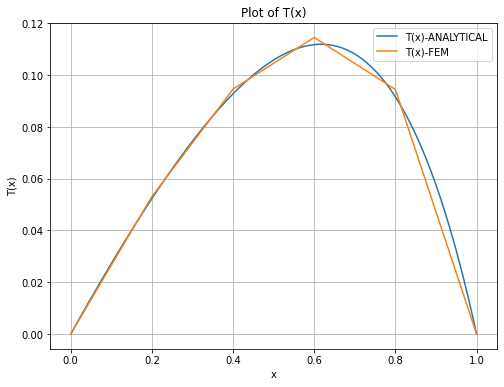

In [7]:
t= np.insert(t, 0, T1)
t= np.insert(t, 5, T6)
x=np.linspace(0,1,6)
print(x)
print(t)

# Plot T against x
plt.figure(figsize=(8, 6))
plt.plot(x_values, T_values, label='T(x)-ANALYTICAL')
plt.plot(x, t, label='T(x)-FEM')
plt.xlabel('x')
plt.ylabel('T(x)')
plt.title('Plot of T(x)')
plt.grid(True)
plt.legend()
plt.show()